# Climate State Finder

The goal of this notebook is to develop a generalized climate state finder. Based on user selected variable and event definitions, this notebook will search all simulations to find these climate states. The inputs required are:

* Domain, a custom shapefile
* One variable
* GWL

## Make Selections

Before running this notebook, make the following selections for variables, spatial domain, and GWLs.

1. Select a timescale - this will impact which downscaling methods are available and which variables are available.

In [1]:
timescale = "monthly" # options are hourly, daily or monthly

2. Select a variable - the code below displays which variables are available based on your timescale options.

In [2]:
# import function 
from climakitae.explore.agnostic import (
  show_available_vars
)

In [3]:
# display variables available for this analysis 
# only showing dynamical because statistical has a smaller subset that is in the larger dynamical subset
# only difference is max/min RH is available in statistical and not in dynamical 
show_available_vars("Dynamical", timescale)

['Air Temperature at 2m',
 'Precipitation (total)',
 'Relative humidity',
 'Dew point temperature',
 'Mean wind speed at 10m',
 'Maximum wind speed at 10m',
 'Surface Pressure',
 'Specific humidity at 2m',
 'Surface skin temperature',
 'Maximum air temperature at 2m',
 'Minimum air temperature at 2m',
 'Instantaneous downwelling longwave flux at bottom',
 'Instantaneous downwelling shortwave flux at bottom',
 'Shortwave flux at the surface',
 'Longwave flux at the surface',
 'Sensible heat flux at the surface',
 'Latent heat flux at the surface',
 'Ground heat flux',
 'Snowfall',
 'Liquid water path',
 'Evaporation',
 'Ice water path',
 'Maximum precipitation']

In [4]:
# make selection from list above
climate_variable = "Precipitation (total)"
climate_units = "inches"

3. Select a baseline and future GWL

In [5]:
# current options 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0
baseline_gwl = "0.8"
future_gwl = "2.0"

4. Select Spatial Domain - provide a shapefile to clip data to

In [6]:
# edit path below and filename for shapefile to use

shapefile_filename = "PajaroRiverWatershed.zip" # replace ellipsis with filepath
spatial_domain_name = "Pajaro" # name will appear in title

5. Select Resolution - select the the model resolution (3km, 9km, 45 km)

In [7]:
resolution = "3 km"

6. Aggregation Method - select a method to aggregate spatially and temporally (to monthly values)

In [8]:
aggregation = "mean" # options are mean, median, sum

7. Climate State Duration - how often should the climate state be observed to be considered a 'hit' 

In [9]:
# duration (in months)
duration = 24 

## Import libraries & define functions

In [10]:
import climakitae as ck 
from climakitae.core.data_interface import (
    get_data_options, 
    get_subsetting_options, 
    get_data
)
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.core.data_load import load

import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def clip_to_shapefile(da, shapefile):
    """
    Clip a DataArray to the boundaries of a shapefile.

    Parameters:
    - da: xarray DataArray to be clipped
    - shapefile: path to the shapefile

    Returns:
    - Clipped DataArray
    """
    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile)

    # Ensure the DataArray has a CRS set
    #da.rio.write_crs("epsg:2228", inplace=True)

    # Clip the DataArray using the shapefile geometry
    clipped_da = da.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

    return clipped_da

## Pull Data

### Dynamical Downscaling (wrf)

In [12]:
# WRF downscaling
wrf_data =get_data(
        variable = climate_variable, 
        downscaling_method = "Dynamical", 
        resolution = resolution, 
        timescale = timescale, 
        units = climate_units,
        # Modify your approach 
        approach = "Warming Level",
        warming_level= [float(baseline_gwl), float(future_gwl)],
    )

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.


In [13]:
# rename lat lon
wrf_data=wrf_data.rename({'x': 'longitude','y': 'latitude'})

In [14]:
# add a dummy time variable
wrf_data = add_dummy_time_to_wl(wrf_data)

### Statistical Downscaling (LOCA2)

In [15]:
# grab correct variable name for LOCA2
loca_variable = [climate_variable]
# temperature
if loca_variable[0] == "Air Temperature at 2m":
    loca_variable = ["Maximum air temperature at 2m", "Minimum air temperature at 2m"]
# relative humidity
if loca_variable[0] == "Relative humidity":
    loca_variable = ["Minimum relative humidity", "Maximum relative humidity"]

In [16]:
# statistical - LOCA2 downscaling variable
loca_data = [get_data(
        variable = GETVAR, 
        downscaling_method = "Statistical", 
        resolution = resolution, 
        units = climate_units,
        timescale = timescale, 
        # Modify your approach 
        approach = "Warming Level",
        warming_level= [float(baseline_gwl),float(future_gwl)],
    ) for GETVAR in loca_variable]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.


In [17]:
# if we need to average 
if loca_data[0] is not None:
    # temperature
    if climate_variable == "Air Temperature at 2m":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Air Temperature at 2m"
        
    # relative humidity
    if climate_variable == "Relative humidity":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Relative humidity"

In [18]:
# unlist if needed
if type(loca_data) == list:
    loca_data = loca_data[0]

# now merge
# first check if there is valid loca data - requires that both x and y have valid data
if loca_data is None:
    # set to wrf
    loca_data = wrf_data
    # replace with all NaNs
    loca_data = loca_data*np.nan
else:
    loca_data=loca_data.rename({'lon': 'longitude','lat': 'latitude'})

In [19]:
# add a dummy time variable
loca_data = add_dummy_time_to_wl(loca_data)

## Prepare Data

In [20]:
# clip to shapefile
wrf_data = clip_to_shapefile(wrf_data, shapefile_filename)
loca_data = clip_to_shapefile(loca_data, shapefile_filename)

In [21]:
# create monthly aggegations
if timescale != "monthly":
    wrf_data = eval(f"wrf_data.resample(time = '1M').{aggregation}()")
    loca_data = eval(f"loca_data.resample(time = '1M').{aggregation}()")

In [22]:
# average across domain (we want single timeseries)
wrf_data = eval(f"wrf_data.{aggregation}(['longitude','latitude'])")
loca_data = eval(f"loca_data.{aggregation}(['longitude','latitude'])")

## Import Data

In [23]:
loca_data = load(loca_data, progress_bar=True)
wrf_data = load(wrf_data, progress_bar=True)

Processing data to read 725.62 KB of data into memory... 
[########################################] | 100% Completed | 260.46 s
Complete!
Processing data to read 22.50 KB of data into memory... 
[########################################] | 100% Completed | 11.07 s
Complete!


## Calculate Anomaly 

### Calculate climatological mean of baseline gwl

In [24]:
# calculate monthly mean for each simulation for the baseline gwl
loca_clim_mean = loca_data.sel(warming_level = float(baseline_gwl)).groupby("time.month").median()
wrf_clim_mean = wrf_data.sel(warming_level = float(baseline_gwl)).groupby("time.month").median()

### Calculate anomaly of future gwl to climatological mean

In [25]:
# subtract the monthly climatology from the future gwl data to create an anomaly
loca_anom = loca_data.sel(warming_level = float(future_gwl)).groupby("time.month") - loca_clim_mean
wrf_anom = wrf_data.sel(warming_level = float(future_gwl)).groupby("time.month") - wrf_clim_mean

### Calculate Seasonal Rolling Average Anomaly

In [26]:
loca_anom = loca_anom.rolling(time=duration).median()
wrf_anom= wrf_anom.rolling(time=duration).median()

## Define Climate States 

In [27]:
# calculate historical anomaly
hist_loca_anom = loca_data.sel(warming_level = float(baseline_gwl)).groupby("time.month") - loca_clim_mean
hist_wrf_anom = wrf_data.sel(warming_level = float(baseline_gwl)).groupby("time.month") - wrf_clim_mean

In [28]:
# calculate the seasonal rolling average
hist_loca_anom = hist_loca_anom.rolling(time=duration).median()
hist_wrf_anom = hist_wrf_anom.rolling(time=duration).median()

In [29]:
# Create an upper and lower threshold 
locaHigh = hist_loca_anom.quantile(q=0.75,dim="time")
locaLow = hist_loca_anom.quantile(q=0.25,dim="time")
wrfHigh = hist_wrf_anom.quantile(q=0.75,dim="time")
wrfLow = hist_wrf_anom.quantile(q=0.25,dim="time")

In [30]:
# add to data array
wrf_anom = wrf_anom.assign_coords(climate_state_high = ("simulation",wrfHigh.values))
wrf_anom = wrf_anom.assign_coords(climate_state_low = ("simulation",wrfLow.values))
loca_anom = loca_anom.assign_coords(climate_state_high = ("simulation",locaHigh.values))
loca_anom = loca_anom.assign_coords(climate_state_low = ("simulation",locaLow.values))

In [31]:
### create a 'hit' for in climate state
# initialize an array to fill
wrfClimateHit = np.zeros(wrf_anom.values.shape)
locaClimateHit = np.zeros(loca_anom.values.shape)

# loop through each time stamp
for itime in range(0,len(wrf_anom["time"])):
    # look at this time stamp + duration 
    timeIndex = list(range(itime,(itime+duration)))
    # remove any values that are greater than our time
    timeIndex = [x for x in timeIndex if x < len(wrf_anom["time"])]

    ### Start with WRF
    # pull out the data to test
    testWRFData = wrf_anom[timeIndex,:]
    
    # for each simulation, check if the values are greater (less) than upper (lower) threshold
    wrfHighCounts = (testWRFData > wrfHigh).sum(dim="time")
    wrfLowCounts = (testWRFData < wrfLow).sum(dim="time")

    # if you have greater than or equal to duration, count as a 'hit'
    wrfHighHitIndex = (wrfHighCounts >= duration)
    wrfLowHitIndex = (wrfLowCounts >= duration)

    # now save hits
    wrfClimateHit[np.ix_(timeIndex,wrfHighHitIndex)]  = 1 
    wrfClimateHit[np.ix_(timeIndex,wrfLowHitIndex)] = -1 

    ### Move to LOCA2
    # pull out the data to test
    testLOCAData = loca_anom[timeIndex,:]
    
    # for each simulation, check if the values are greater (less) than upper (lower) threshold
    locaHighCounts = (testLOCAData > locaHigh).sum(dim="time")
    locaLowCounts = (testLOCAData < locaLow).sum(dim="time")

    # if you have greater than or equal to duration, count as a 'hit'
    locaHighHitIndex = (locaHighCounts >= duration)
    locaLowHitIndex = (locaLowCounts >= duration)

    # now save hits
    locaClimateHit[np.ix_(timeIndex,locaHighHitIndex)] = 1 
    locaClimateHit[np.ix_(timeIndex,locaLowHitIndex)] = -1 

In [32]:
# now add hits to xarray
wrf_anom = wrf_anom.assign_coords(climate_state_hit = (("time","simulation"),wrfClimateHit))
loca_anom = loca_anom.assign_coords(climate_state_hit = (("time","simulation"),locaClimateHit))

## Prep for Plotting

In [33]:
# create a 'model' variable
lsims=loca_anom.simulation.values.tolist()
loca_models = [s.split("_")[1] for s in lsims]
loca_anom = loca_anom.assign_coords(models = ("simulation",loca_models))

In [34]:
wsims=wrf_anom.simulation.values.tolist()
wrf_models = [s.split("_")[1] for s in wsims]
wrf_anom = wrf_anom.assign_coords(models = ("simulation",wrf_models))

In [35]:
# create a realization variable
loca_realization = [s.split("_")[2]+'_'+s.split("_")[3] for s in lsims]
loca_anom = loca_anom.assign_coords(realization = ("simulation",loca_realization))
wrf_realization = [s.split("_")[2]+'_'+s.split("_")[3] for s in wsims]
wrf_anom = wrf_anom.assign_coords(realization = ("simulation",wrf_realization))

In [41]:
# create a data frame to make plotting easier
locaDF = loca_anom_hourly.to_dataframe().reset_index()
wrfDF = wrf_anom_hourly.to_dataframe().reset_index()

In [42]:
# Create a downscaling name
locaDF["downscaling"] = "loca2"
wrfDF["downscaling"] = "wrf"

In [43]:
# combine into one 
finalDF = pd.concat([locaDF, wrfDF],keys=locaDF.keys())

## Plot Yay!

AttributeError: 'DataFrame' object has no attribute 'climate_state_hit'

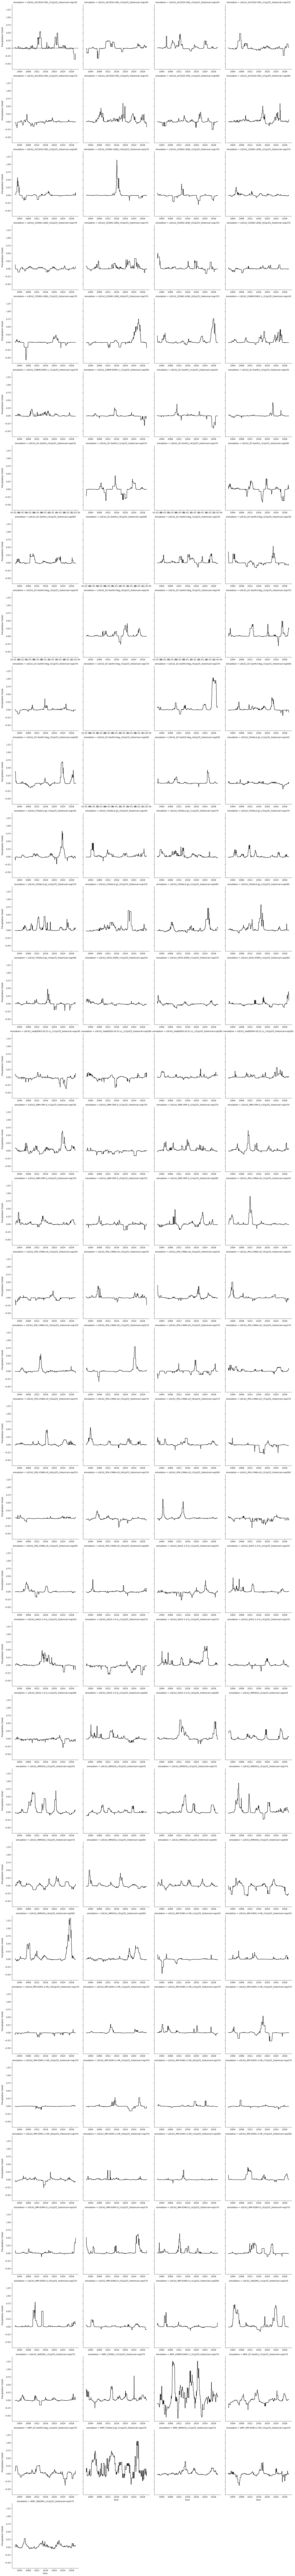

In [44]:
# plot all the data 
def annotate(data, **kws):
    ax = plt.gca()
    ax.axhline(0, ls='--',color="black")
    ax.fill_between(data.time,data[climate_variable],where=data.climate_state_hit == 1,facecolor='maroon',alpha=.5)
    ax.fill_between(data.time,data[climate_variable],where=data.climate_state_hit == -1,facecolor='darkblue',alpha=.5)
g1 = sns.relplot(
    data=finalDF,
    x="time", y=climate_variable,
    col="simulation",color="black",col_wrap=4,
    kind="line", 
    height=5, aspect=1, facet_kws=dict(sharex=False), 
)
g1.map_dataframe(annotate)

In [41]:
# Save the figure to a file
g1.savefig(f'climate_state_finder_{climate_variable}_under_{future_gwl}gwl_with_{duration}{timescale}duration.jpeg'.replace(" ", "_"))

In [1]:
# add a variable called 'wrf' and 'loca2' into the data
wrf_anom["downscaling"] = "wrf"
loca_anom["downscaling"] = "loca2"

NameError: name 'wrf_anom' is not defined

In [48]:
wrf_anom

<xarray.DataArray np.str_('Precipitation (total)') (time: 360, simulation: 8)> Size: 23kB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.01384802,  0.10274263,  0.0233575 , ..., -0.01408416,
        -0.01412361,  0.03366314],
       [-0.00438651,  0.10274263,  0.02040477, ..., -0.02833134,
        -0.01412361,  0.0517869 ],
       [-0.00438651,  0.13371451,  0.02040477, ..., -0.02833134,
        -0.00308501,  0.03366314]], shape=(360, 8))
Coordinates:
  * simulation          (simulation) <U44 1kB 'WRF_CESM2_r11i1p1f1_historical...
  * time                (time) datetime64[ns] 3kB 2000-01-01 ... 2029-12-01
    Lambert_Conformal   (time) int64 3kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    month               (time) int64 3kB 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
    climate_state_high  (simulation) float64 64B 0.04534 0.154 ... 0.03863
    climate_state_low   (simulation) float64 64B -0.01726 -0.07627 ... -0.02423
    climate_state_hit   (time, simulation) float64 23kB 0.0 0.0 0.0 ... 0.0 0.0
    models              (simulation) <U13 416B 'CESM2' ... 'TaiESM1'
    realization         (simulation) <U27 864B 'r11i1p1f1_historical+ssp370' ...
    downscaling         <U3 12B 'wrf'
Attributes:
    variable_id:           prec
    extended_description:  Total precipitation. Computed by summing total gri...
    units:                 inches
    data_type:             Gridded
    resolution:            3 km
    frequency:             monthly
    location_subset:       ['entire domain']
    approach:              Warming Level
    downscaling_method:    Dynamical
    warming_level_window:  +/- 15 years from centered year
    institution:           UCLA

In [42]:
# save climate state data (to be loaded into event finder)
# add a

In [ ]:
# add a variable

In [43]:
finalDF.to_parquet(f'climate_state_{climate_variable}_under_{future_gwl}gwl_with_{duration}{timescale}duration'.replace(" ", "_"))